!! NOTA: i risultati possono variare tra differenti run quindi i commenti fatti potrebbero non valere su alcune run del programma. !!

In [1]:
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import tensorflow
from keras.models import Sequential
#just import some random layers
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 
The data set includes information about:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-2=no consumption, -1=pay duly, 0=the use of revolving credit, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

In [2]:
#upload e unione dei dati
dfX = pd.read_csv('X_train.csv', header="infer")
print(dfX)
dfy = pd.read_csv('y_train.csv', header="infer")
print(dfy)
df = dfX.join(dfy.set_index('ID'), on='ID')
print(df)

          ID  LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
0      21754    80000.0    2          2  ...    2092.0    1218.0    1445.0     878.0
1        252    30000.0    1          2  ...     851.0     955.0       0.0       0.0
2      22942   180000.0    2          5  ...       0.0    6881.0   10340.0     182.0
3        619    60000.0    1          1  ...    2000.0    1500.0    1900.0    2000.0
4      17091   130000.0    2          2  ...    5000.0    5000.0    5000.0   10700.0
...      ...        ...  ...        ...  ...       ...       ...       ...       ...
23995  29803    50000.0    1          2  ...    1591.0      72.0    1134.0   73421.0
23996   5391   200000.0    1          1  ...       0.0    7500.0    6000.0    4000.0
23997    861    50000.0    1          1  ...       0.0       0.0       0.0       0.0
23998  15796    70000.0    2          2  ...    4500.0    1200.0       0.0    1200.0
23999  23655   160000.0    2          2  ...    3135.0    1650.0 

##Inspecting the data

Eseguo un controllo per individuare eventuali valori nulli all'interno del dataset (non ce ne sono).

In [3]:
# controllo se ci sono valori nulli
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          24000 non-null  int64  
 1   LIMIT_BAL                   24000 non-null  float64
 2   SEX                         24000 non-null  int64  
 3   EDUCATION                   24000 non-null  int64  
 4   MARRIAGE                    24000 non-null  int64  
 5   AGE                         24000 non-null  int64  
 6   PAY_0                       24000 non-null  int64  
 7   PAY_2                       24000 non-null  int64  
 8   PAY_3                       24000 non-null  int64  
 9   PAY_4                       24000 non-null  int64  
 10  PAY_5                       24000 non-null  int64  
 11  PAY_6                       24000 non-null  int64  
 12  BILL_AMT1                   24000 non-null  float64
 13  BILL_AMT2                   240

Analizzo la distribuzione delle istanze rispetto all'attributo di etichettatura.

In [4]:
print(df['default.payment.next.month'].value_counts())

0    18677
1     5323
Name: default.payment.next.month, dtype: int64


## Preparing the data

Posso scartare l'attributo ID dato che non costituisce un attributo sulla base del quale la NN deve imparare.

In [5]:
#discard some features
df.drop('ID', axis=1, inplace=True)
print(df)
print("Dataset shape" + str(df.shape))

       LIMIT_BAL  SEX  ...  PAY_AMT6  default.payment.next.month
0        80000.0    2  ...     878.0                           0
1        30000.0    1  ...       0.0                           0
2       180000.0    2  ...     182.0                           0
3        60000.0    1  ...    2000.0                           0
4       130000.0    2  ...   10700.0                           0
...          ...  ...  ...       ...                         ...
23995    50000.0    1  ...   73421.0                           0
23996   200000.0    1  ...    4000.0                           1
23997    50000.0    1  ...       0.0                           0
23998    70000.0    2  ...    1200.0                           1
23999   160000.0    2  ...    1500.0                           1

[24000 rows x 24 columns]
Dataset shape(24000, 24)


Ribilancio le classi tramite upsampling/downsampling delle istanze, al fine di ottenere numerosità simile tra le due classi. Utilizzo upsampling poichè generalmente migliore.

In [6]:
#balancing the dataset
from sklearn.utils import resample
d_1 = df[df["default.payment.next.month"] == 1]
d_2 = df[df["default.payment.next.month"] == 0]
d_3 = resample(d_1, replace=True, n_samples=18677, random_state=12)
#d_3 = d_2.sample(n=5400, replace=False, random_state=1) or downsampling

df = d_2.append(d_3)
print('nuovo df:')
print(df)
print(df['default.payment.next.month'].value_counts())

nuovo df:
       LIMIT_BAL  SEX  ...  PAY_AMT6  default.payment.next.month
0        80000.0    2  ...     878.0                           0
1        30000.0    1  ...       0.0                           0
2       180000.0    2  ...     182.0                           0
3        60000.0    1  ...    2000.0                           0
4       130000.0    2  ...   10700.0                           0
...          ...  ...  ...       ...                         ...
14821    20000.0    2  ...    2000.0                           1
18732    80000.0    2  ...       0.0                           1
19307    10000.0    1  ...    2000.0                           1
5082     70000.0    2  ...    5500.0                           1
17183   200000.0    1  ...    2000.0                           1

[37354 rows x 24 columns]
1    18677
0    18677
Name: default.payment.next.month, dtype: int64


Divisione tra train e test (90% e 10%)

In [7]:
X = df.loc[:, df.columns != "default.payment.next.month"]
Y = df["default.payment.next.month"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

Scalo tutti i valori tra -1 e 1

In [8]:
# binary classification
nb_classes = 1

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

scaler = preprocessing.MinMaxScaler((-1, 1))
scaler.fit(X.values)

XX_train = scaler.transform(X_train.values)
XX_test = scaler.transform(X_test.values)

YY_train = Y_train.values
YY_test = Y_test.values


## Building the network

Ho deciso di creare una rete con livelli di numerosità decrescente per, idealmente, far convergere all'ultimo livello le feature più importanti in pochi neuroni. Ho utilizzato la relu come funzione di attivazione perchè efficace e veloce. All'ultimo livello invece si è utilizzata la sigmoid function. Il metodo di ottimizzazione utilizzato è il stocastic gradient descend, mentre la loss function utilizzata è la binary_crossentropy, poichè si ha a che fare con un problema di classificazione binaria.

In [9]:
# binary classification:

# init model
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(23,)))
# FC @ 128, non-linear
model.add(Dense(128, activation='relu'))
# FC @ 64, non-linear
model.add(Dense(64, activation='relu'))
# FC @ 32, non linear
model.add(Dense(32, activation='relu'))
# FC @ 16, non linear
model.add(Dense(16, activation='relu'))
# FC @ 8, non linear
model.add(Dense(8, activation='relu'))
# output layer
model.add(Dense(nb_classes, activation='sigmoid'))

# compile
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy',])



In [10]:
#get the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6144      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

Si è deciso di utilizzare n_epochs = 25 poichè facendo alcuni tentativi, mantenendo fissi gli altri parametri, la validation loss iniziava ad aumentare se si utilizzava un valore maggiore di iterazioni, 
divergendo dalla training loss: il modello stava andando in overfitting. L'accuracy del training set invece migliorava costantemente, mentre quella del validation set aumentava leggermente fino a n_epochs=25 per poi rimanere pressochè uguale e con più fluttuazioni(più rumorosa).
Per quanto riguarda la batch_size invece è stato scelto 32 poichè con valori maggiori accuracy e loss del validation diventavano più irregolari, mentre con valori minori il processo risultava troppo lento. 32 quindi si è rivelato un buon compromesso.

In [11]:
#train

n_epochs = 25
batch_size = 32

history = model.fit(XX_train, YY_train, epochs=n_epochs, batch_size=batch_size, validation_split = 0.3)  

Epoch 1/25
736/736 [==============================] - 4s 5ms/step - loss: 0.6789 - accuracy: 0.6414 - val_loss: 0.6591 - val_accuracy: 0.6701
Epoch 2/25
736/736 [==============================] - 3s 4ms/step - loss: 0.6274 - accuracy: 0.6767 - val_loss: 0.6111 - val_accuracy: 0.6549
Epoch 3/25
736/736 [==============================] - 3s 4ms/step - loss: 0.5983 - accuracy: 0.6889 - val_loss: 0.5926 - val_accuracy: 0.6942
Epoch 4/25
736/736 [==============================] - 3s 4ms/step - loss: 0.5924 - accuracy: 0.6905 - val_loss: 0.5916 - val_accuracy: 0.6909
Epoch 5/25
736/736 [==============================] - 3s 4ms/step - loss: 0.5898 - accuracy: 0.6934 - val_loss: 0.5878 - val_accuracy: 0.6935
Epoch 6/25
736/736 [==============================] - 3s 4ms/step - loss: 0.5870 - accuracy: 0.6931 - val_loss: 0.5834 - val_accuracy: 0.6945
Epoch 7/25
736/736 [==============================] - 3s 4ms/step - loss: 0.5845 - accuracy: 0.6965 - val_loss: 0.5815 - val_accuracy: 0.6944
Epoch 

## Analyze and comment the training results && Validate the model and comment the results

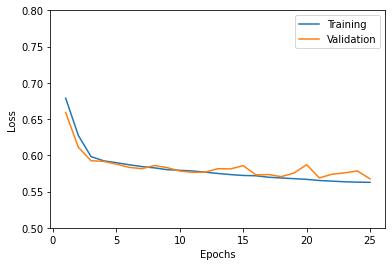

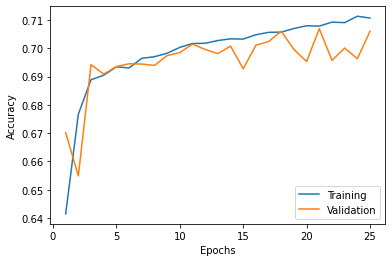

In [12]:
#plot training history

from matplotlib import pyplot as plt
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0.5,0.8)
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history)

I commenti sui grafici sono implicitamente già stati fatti in parte nella scelta degli iperparametri. Possiamo comunque notare come la curva della loss sia decrescente: indicatore positivo. L'accuracy invece è crescente e tra training e validation non abbiamo divergenza: segnale positivo perchè non c'è overfitting.


## Make predictions (on the provided test set)


In [13]:
# calcolo di performance score(su test set)
score = model.evaluate(XX_test, YY_test, batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("\n%s: %.2f" % (model.metrics_names[0], score[0]))

117/117 [==============================] - 0s 2ms/step - loss: 0.5717 - accuracy: 0.7056

accuracy: 70.56%

loss: 0.57


Otteniamo valori in linea con il validation test: abbiamo tenuto un buon livello di generalizzazione, nonostante le performance in sè non siano delle migliori: 70% di accuracy è un po' basso.

Mostriamo come vengono fatte le predictions all'ultimo livello: dal momento che abbiamo un problema di classificazione binaria utilizziamo il thresholding: i valori minori di 0.5 vengono etichettati come 0 e quelli maggiori come 1.

In [14]:
predictions = model.predict(XX_test)
print('predictions shape:', predictions.shape)
predictions[:10]

predictions shape: (3736, 1)


array([[0.89547557],
       [0.85053474],
       [0.32935965],
       [0.16808549],
       [0.42475995],
       [0.426651  ],
       [0.34214053],
       [0.78182006],
       [0.57349753],
       [0.3063311 ]], dtype=float32)

In [15]:
y_classes = (predictions > 0.5).astype(np.int8)
print(np.equal(y_classes, np.round(predictions)).all())
y_classes[:10], YY_test[:10]

True


(array([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=int8), array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0]))

Dalla tabella seguente invece possiamo fare qualche osservazione specifica per il valore di classificazione determinato: precision,recall e f1-score hanno tutti dei valori abbastanza simili tra classe 0 e 1. Ciò può indicare che l'upsampling effettuato in partenza è risultato efficace. Poichè l'upsampling è stato eseguito prima della divisione tra training set e test set ma le misure di valutazione delle performance appena citate risultano simili tra due classi, non è necessario fare ragionamenti che ci riconducano alla distribuzione sbilanciata iniziale in cui l'etichetta 0 costituiva più dei 3/4 del totale. In caso contrario avremmo dovuto ad esempio rivalutare il valore di accuracy in base alla distribuzione iniziale.

In [16]:
from sklearn.metrics import classification_report
print(classification_report(YY_test,y_classes))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1841
           1       0.77      0.60      0.67      1895

    accuracy                           0.71      3736
   macro avg       0.72      0.71      0.70      3736
weighted avg       0.72      0.71      0.70      3736



# OPTIONAL -- Export the predictions in the format indicated in the assignment release page.

In [17]:
dfX_test = pd.read_csv('X_test.csv', header="infer")
dfX_test.drop('ID', axis=1, inplace=True)

X_test2 = dfX_test.astype('float32')

scaler2 = preprocessing.MinMaxScaler((-1, 1))
scaler2.fit(dfX_test.values)

XX_test2 = scaler.transform(X_test2.values)

prediction_test2 = model.predict(XX_test2)
print('predictions shape:', prediction_test2.shape)
prediction_test2[:10]

y_classes2 = (prediction_test2 > 0.5).astype(np.int8)
print(np.equal(y_classes2, np.round(prediction_test2)).all())
y_classes2.tofile('punti2', sep='\n', format='%s')
y_classes2[:20]


predictions shape: (6000, 1)
True


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0]], dtype=int8)